# mapping out inheritance structures in yt

(`pyenv activate yt_dev`)



a yt frontend: a `Dataset` class that implements some "abstract" classes:

```
class GadgetDataset(SPHDataset):
    _index_class: Type[Index] = GadgetBinaryIndex
    _file_class: Type[ParticleFile] = GadgetBinaryFile
    _field_info_class: Type[FieldInfoContainer] = GadgetFieldInfo
```

The `_index_class` has an another attached "abstract" class, `_index_class.io` that each frontend implements, in this case, `IOHandlerGadgetHDF5`. Each of these classes have methods that may or may not need to be re-written for each frontend... there's a fair bit of code duplication, how to identify code structure that could be better abstracted?

Help simplify writing new frontends, daskification...


Concentrating on the most dask-relevant part of this, the `io` classes, want to know **how classes implement specific methods**. e.g., how does `io._read_particle_selection` and `io._read_particle_coords` compare between frontends?


# 0. where this is going

In [1]:
import yt
from inheritance_explorer import ClassGraphTree

base_class = yt.utilities.io_handler.BaseIOHandler
fname = "_read_particle_selection"

cgt = ClassGraphTree(base_class, funcname=fname) # traces an inheritance tree
graph = cgt.build_interactive_graph(width="1200px", 
                                    height="800px", 
                                    bgcolor='#222222', 
                                    font_color='white') # constructs a pyvis interactive graph
graph.show('tmp.html')  # a pyvis interactive graph

* Nodes: child classes, hover shows the class name with its direct parent class
* Gray edges: point from child to parent classes
* Blue-Purple nodes: this child over-rides the selected function
* blue edges: connect child classes that over-ride the selected function AND are greater than 75% similar
* isolated blue-purple nodes = over-rides that are below similarity cutoff (75%)

{0: 'BaseIOHandler',
 1: 'IOHandlerGadgetFOFHaloHDF5',
 2: 'IOHandlerYTHalo',
 3: 'IOHandlerOpenPMDHDF5'}

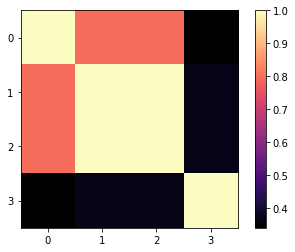

In [2]:
labels, ax = cgt.plot_similarity()
labels  # note that labels are not correct here...

## How to get here:

1. walking the inheritance tree & graph construction
2. pulling source code & calculating similarity
3. making it interactive

# 1. walking the inheritance tree & graph construction

### Manual inspection of classes

In [3]:
# looking for children:
from yt.utilities.io_handler import BaseIOHandler, BaseParticleIOHandler
BaseIOHandler.__subclasses__()  # all the classes that override BaseIOHandler

[yt.utilities.io_handler.BaseParticleIOHandler,
 yt.utilities.io_handler.IOHandlerExtracted,
 yt.frontends.amrvac.io.AMRVACIOHandler,
 yt.frontends.art.io.IOHandlerART,
 yt.frontends.artio.io.IOHandlerARTIO,
 yt.frontends.athena.io.IOHandlerAthena,
 yt.frontends.athena_pp.io.IOHandlerAthenaPP,
 yt.frontends.boxlib.io.IOHandlerBoxlib,
 yt.frontends.chombo.io.IOHandlerChomboHDF5,
 yt.frontends.enzo_e.io.EnzoEIOHandler,
 yt.frontends.enzo.io.IOHandlerPackedHDF5,
 yt.frontends.enzo.io.IOHandlerInMemory,
 yt.frontends.exodus_ii.io.IOHandlerExodusII,
 yt.frontends.fits.io.IOHandlerFITS,
 yt.frontends.flash.io.IOHandlerFLASH,
 yt.frontends.flash.io.IOHandlerFLASHParticle,
 yt.frontends.gamer.io.IOHandlerGAMER,
 yt.frontends.moab.io.IOHandlerMoabH5MHex8,
 yt.frontends.moab.io.IOHandlerMoabPyneHex8,
 yt.frontends.nc4_cm1.io.CM1IOHandler,
 yt.frontends.open_pmd.io.IOHandlerOpenPMDHDF5,
 yt.frontends.ramses.io.IOHandlerRAMSES,
 yt.frontends.stream.io.IOHandlerStream,
 yt.frontends.stream.io.IOHan

In [4]:
BaseParticleIOHandler.__subclasses__()

[yt.frontends.adaptahop.io.IOHandlerAdaptaHOPBinary,
 yt.frontends.ahf.io.IOHandlerAHFHalos,
 yt.frontends.sph.io.IOHandlerSPH,
 yt.frontends.gadget_fof.io.IOHandlerGadgetFOFHDF5,
 yt.frontends.gdf.io.IOHandlerGDFHDF5,
 yt.frontends.halo_catalog.io.IOHandlerYTHaloCatalog,
 yt.frontends.http_stream.io.IOHandlerHTTPStream,
 yt.frontends.owls_subfind.io.IOHandlerOWLSSubfindHDF5,
 yt.frontends.rockstar.io.IOHandlerRockstarBinary,
 yt.frontends.sdf.io.IOHandlerSDF,
 yt.frontends.stream.io.StreamParticleIOHandler]

In [5]:
from yt.frontends.sph.io import IOHandlerSPH
IOHandlerSPH.__subclasses__()

[yt.frontends.gadget.io.IOHandlerGadgetHDF5,
 yt.frontends.gadget.io.IOHandlerGadgetBinary,
 yt.frontends.swift.io.IOHandlerSwift,
 yt.frontends.tipsy.io.IOHandlerTipsyBinary]

So, need to assemble recursively! 

In [6]:
all_subclasses = []
def subclasses_assemble(parent):
    for child in parent.__subclasses__(): 
        all_subclasses.append(child)  # add the name        
        subclasses_assemble(child)  # continue downward... 
    
subclasses_assemble(BaseParticleIOHandler)
all_subclasses

[yt.frontends.adaptahop.io.IOHandlerAdaptaHOPBinary,
 yt.frontends.ahf.io.IOHandlerAHFHalos,
 yt.frontends.sph.io.IOHandlerSPH,
 yt.frontends.gadget.io.IOHandlerGadgetHDF5,
 yt.frontends.arepo.io.IOHandlerArepoHDF5,
 yt.frontends.owls.io.IOHandlerOWLS,
 yt.frontends.eagle.io.IOHandlerEagleNetwork,
 yt.frontends.gadget.io.IOHandlerGadgetBinary,
 yt.frontends.swift.io.IOHandlerSwift,
 yt.frontends.tipsy.io.IOHandlerTipsyBinary,
 yt.frontends.gadget_fof.io.IOHandlerGadgetFOFHDF5,
 yt.frontends.gadget_fof.io.IOHandlerGadgetFOFHaloHDF5,
 yt.frontends.gdf.io.IOHandlerGDFHDF5,
 yt.frontends.halo_catalog.io.IOHandlerYTHaloCatalog,
 yt.frontends.halo_catalog.io.IOHandlerYTHalo,
 yt.frontends.http_stream.io.IOHandlerHTTPStream,
 yt.frontends.owls_subfind.io.IOHandlerOWLSSubfindHDF5,
 yt.frontends.rockstar.io.IOHandlerRockstarBinary,
 yt.frontends.sdf.io.IOHandlerSDF,
 yt.frontends.sdf.io.IOHandlerHTTPSDF,
 yt.frontends.sdf.io.IOHandlerSIndexSDF,
 yt.frontends.sdf.io.IOHandlerSIndexHTTPSDF,
 yt.f

that's just a list, we want to track the actual inheritance hierarchy

### graph visualization with pydot/pyvis

pydot (https://github.com/pydot/pydot): pure python interface for graphviz 

pyvis (https://pyvis.readthedocs.io/en/latest/): another graph package, has nice interactivity

both have similar usage

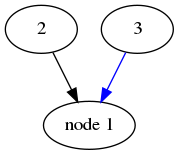

In [7]:
import pydot
dig = pydot.Dot("graph_name", graph_type="digraph") # a directed graph (di-graph)

dig.add_node(pydot.Node('1',label='node 1'))
dig.add_node(pydot.Node('2'))
dig.add_node(pydot.Node('3'))

# Add edge between 1 and 2, 3 and 1
dig.add_edge(pydot.Edge('2','1'))
dig.add_edge(pydot.Edge('3','1',color='blue'))

from IPython.core.display import Image  # nice trickery for displaying in a notebook
Image(dig.create_png())

### inheritance digraph with yt

Recursively construct inheritance structure, **highlighting when a class defines or overrides a specified function**

In [8]:
import collections
import inspect
import pydot
from typing import Optional, Any

class ChildNode:
    # a class that is a child of some parent
    def __init__(self, 
                 child: Any, 
                 child_id: int, 
                 parent: Optional[Any]=None, 
                 parent_id: Optional[int]=None,
                 color: Optional[str]="#000000"):
        self.child = child
        self.child_name = child.__name__
        self._child_id = child_id
        self.parent = parent
        
        self._parent_id = parent_id
        self.parent_name = None
        if parent:
            self.parent_name = parent.__name__
            
        self.color = color
    
    @property
    def child_id(self) -> str:
        return str(self._child_id)
    
    @property
    def parent_id(self) -> str:        
        if self._parent_id:            
            return str(self._parent_id)
        return
    
        
class ClassGraphTree:
    
    def __init__(self, 
                 baseclass: Any, 
                 funcname: Optional[str]=None, 
                 default_color: Optional[str]= "#000000",
                 func_override_color: Optional[str]= "#ff0000",
                 **kwargs):
        """
        baseclass: 
            the starting base class to begin mapping from
        funcname: 
            the name of a function to watch for overrides
        default_color: t
            he default outline color of nodes, in any graphviz string
        func_override_color: 
            the outline color of nodes that override funcname, in any graphviz string
        **kwargs:
            any additional keyword arguments are passed to graphviz.Digraph(**kwargs)
        """
        self.baseclass = baseclass
        self.basename: str = baseclass.__name__
        self.funcname = funcname
        self.dot = pydot.Dot(f"{baseclass}", graph_type="digraph", **kwargs)
        self._nodenum: int = 0
        self._node_list = []        
        self._current_node = 1                
        self._default_color = default_color
        self._override_color = func_override_color
        self.build()
        
    def _get_source_info(self, obj) -> Optional[str]:
        f = getattr(obj, self.funcname)
        if isinstance(f, collections.abc.Callable):
            return f"{inspect.getsourcefile(f)}:{inspect.getsourcelines(f)[1]}"
        return None
    
    def _node_overrides_func(self, child, parent) -> bool:
        # compare where the function is defined
        childsrc = self._get_source_info(child)
        parentsrc = self._get_source_info(parent)
        if childsrc != parentsrc:            
            return True # it overrides! 
        return False        

    def _get_new_node_color(self, child, parent) -> str:
        if self.funcname and self._node_overrides_func(child, parent):
            return self._override_color
        return self._default_color

    def _get_baseclass_color(self) -> str:
        color = self._default_color        
        if self.funcname:
            f = getattr(self.baseclass, self.funcname)
            class_where_its_defined = f.__qualname__.split('.')[0]
            if self.basename == class_where_its_defined: 
                # then its defined here, use the override color
                color = self._override_color
        return color
        
    
    def check_subclasses(self, parent, parent_id: int, node_i: int) -> int:
        for child in parent.__subclasses__():            
            color = self._get_new_node_color(child, parent) # color changes if overridden
            new_node = ChildNode(child, node_i, parent=parent, parent_id=parent_id, color=color)            
            self._node_list.append(new_node)
            
            node_i += 1
            node_i = self.check_subclasses(child, node_i - 1, node_i)
        return node_i
            
            
    def build(self):
        # builds a list of nodes with references for inheritance 
        
        # initialize with the top node       
        color = self._get_baseclass_color()        
        self._node_list.append(ChildNode(self.baseclass, self._current_node, parent=None, color=color))
        self._current_node += 1
        
        # recursively follow the subclasses
        _ = self.check_subclasses(self.baseclass, self._current_node - 1, self._current_node)        
            
        # now build the graph
        for node in self._node_list:
            dotnode = pydot.Node(node.child_id, 
                                 label=node.child_name, 
                                 color=node.color)
            self.dot.add_node(dotnode)
            if node.parent:
                edge = pydot.Edge(node.child_id, node.parent_id)
                self.dot.add_edge(edge)

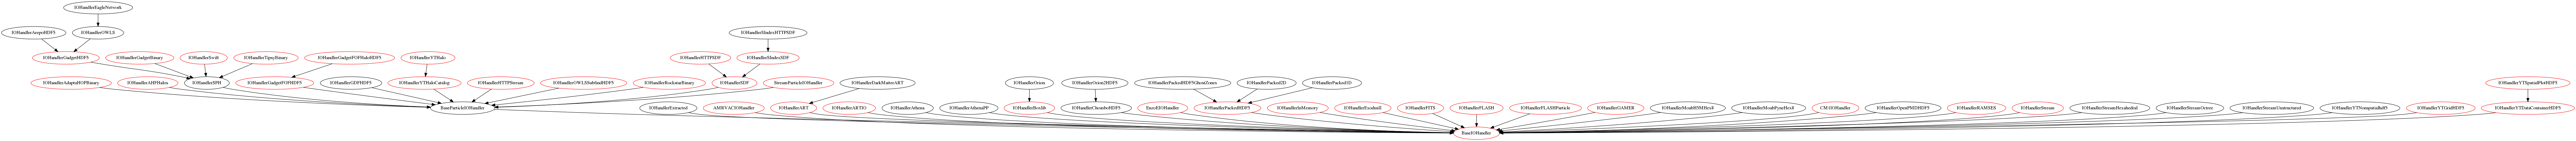

In [9]:
from yt.utilities.io_handler import BaseIOHandler
from IPython.core.display import Image
c = ClassGraphTree(BaseIOHandler, "_read_particle_coords")
Image(c.dot.create_png(), unconfined=True)

so now we know which frontends over ride our chosen function... but how similar is the function between each?

# 2. pulling source code & calculating similarity

In [10]:
import inspect
from yt.frontends.gadget.io import IOHandlerGadgetBinary

inspect.getsourcefile(IOHandlerGadgetBinary._read_particle_coords)

'/home/chavlin/src/yt_general/yt/yt/frontends/gadget/io.py'

In [11]:
inspect.getsourcefile(IOHandlerGadgetBinary._read_particle_selection)

'/home/chavlin/src/yt_general/yt/yt/utilities/io_handler.py'

In [12]:
inspect.getsourcelines(IOHandlerGadgetBinary._read_particle_selection)

(['    def _read_particle_selection(\n',
  '        self, chunks, selector, fields: List[Tuple[str, str]]\n',
  '    ) -> Mapping[Tuple[str, str], np.ndarray]:\n',
  '        rv = {}  # the return dictionary\n',
  '        ind = {}  # holds the most recent max index of the return arrays by field\n',
  '\n',
  '        # Initialize containers for tracking particle, field information\n',
  '        # ptf (particle field types) maps particle type to list of on-disk fields to read\n',
  '        # psize maps particle type to on-disk size across chunks\n',
  '        # fsize maps particle type to size of return values\n',
  '        # field_maps stores fields, accounting for field unions\n',
  '        ptf: DefaultDict[str, List[str]] = defaultdict(list)\n',
  '        psize: DefaultDict[str, int] = defaultdict(lambda: 0)\n',
  '        fsize: DefaultDict[Tuple[str, str], int] = defaultdict(lambda: 0)\n',
  '        field_maps: DefaultDict[Tuple[str, str], List[Tuple[str, str]]] = defaultdi

### Code Similarity

We can pull source code for each of the red nodes over-riding the selected function... how to compare?

https://github.com/fyrestone/pycode_similar is nice and easy: "This is a simple plagiarism detection tool for python code, the basic idea is to normalize python AST representation and use difflib to get the modification from referenced code to candidate code."

AST = abstract syntax trees (https://docs.python.org/3/library/ast.html, https://ruslanspivak.com/lsbasi-part7/)

In [13]:
import pycode_similar
from yt.frontends.swift.io import IOHandlerSwift
from yt.frontends.gadget.io import IOHandlerGadgetHDF5
import textwrap
src_swift = textwrap.dedent(inspect.getsource(IOHandlerSwift._read_particle_coords))
src_gadget = textwrap.dedent(inspect.getsource(IOHandlerGadgetHDF5._read_particle_coords))

In [14]:
# pycode_similar.detect([the reference, cadidate 1, candiate 2, ...])
result = pycode_similar.detect([src_swift, src_swift, src_gadget])
result

[(1, [<pycode_similar.FuncDiffInfo at 0x7fd645db6ee0>]),
 (2, [<pycode_similar.FuncDiffInfo at 0x7fd645dbda60>])]

In [15]:
# comparison of the same function
def pull_result(result, indx):
    return (result[indx][1][0].plagiarism_percent,
            result[indx][1][0].plagiarism_count, 
            result[indx][1][0].total_count)

pull_result(result, 0)


(1.0, 70, 70)

In [16]:
# gadget vs swift
pull_result(result, 1)

(0.5571428571428572, 39, 70)

In [17]:
# swift vs gadget
pull_result(pycode_similar.detect([src_gadget, src_swift]), 0)

(0.6290322580645161, 39, 62)

not symmetric! intrinsic AST complexity or `pycode_similar` oddity? 

averaging from here on:

In [18]:
r1 = pycode_similar.detect([src_swift, src_gadget])
r2 = pycode_similar.detect([src_gadget, src_swift])

(r1[0][1][0].plagiarism_percent + r2[0][1][0].plagiarism_percent)/2

0.5930875576036867

## A new repo based on above

things are getting complicated... new repo: https://github.com/chrishavlin/inheritance_explorer (not yt specific, but not tested on anything other than yt...)


In [19]:
import yt
from inheritance_explorer import ClassGraphTree

In [20]:
base_class = yt.utilities.io_handler.BaseParticleIOHandler
# fname = "_read_particle_selection"
fname = "_read_particle_coords"

In [21]:
cgt = ClassGraphTree(base_class, funcname=fname)

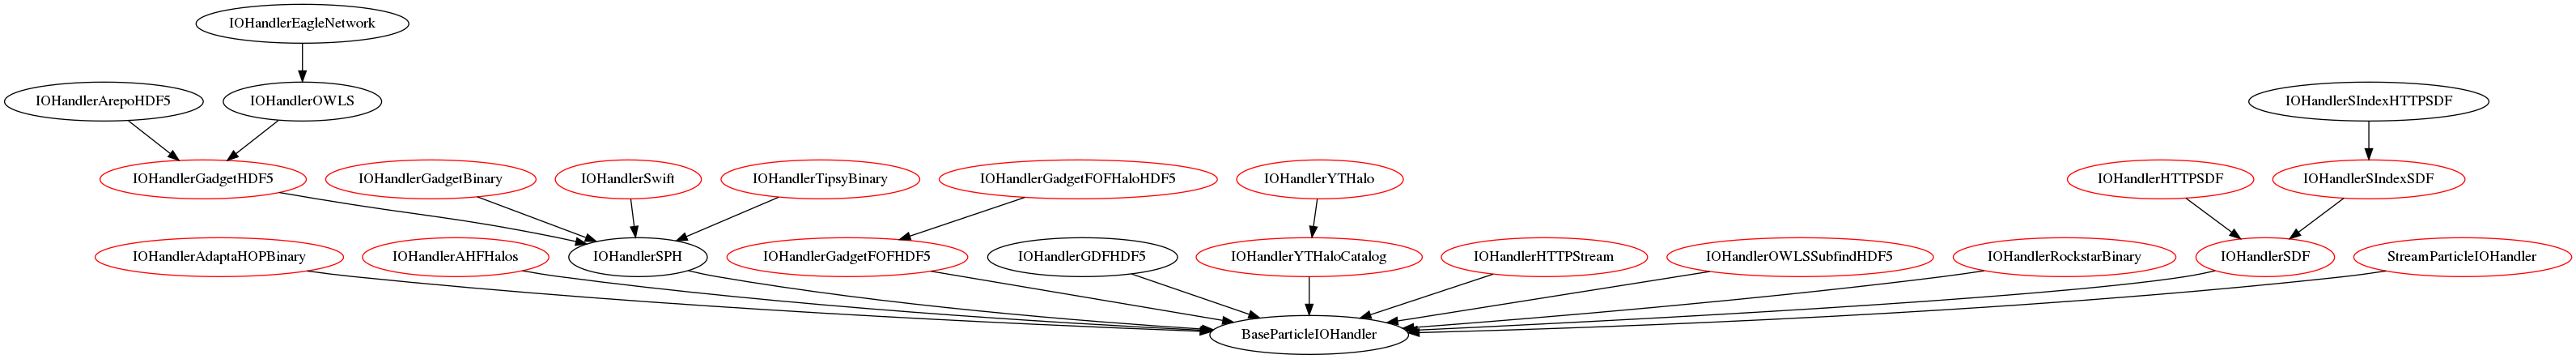

In [22]:
cgt.build_graph(include_similarity=False)
cgt.show_graph()

but now... we store the source code everytime the function gets over-ridden and then do a similarity test for every permuatation to get a "similarity matrix"

In [23]:
M = cgt.similarity_results['matrix']
M.shape

(18, 18)

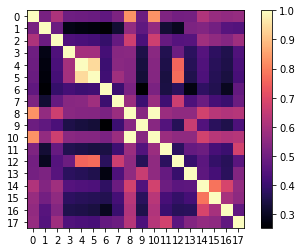

In [24]:
labels, ax = cgt.plot_similarity()

each row and column is a child class, the color is how similar the function source is to other instances of overriding the function:

* diagonal is always 1 (a self comparison)
* symmetric because I'm averaging each comparison direction


In [25]:
labels

{0: 'BaseParticleIOHandler',
 1: 'IOHandlerAdaptaHOPBinary',
 2: 'IOHandlerAHFHalos',
 3: 'IOHandlerGadgetHDF5',
 4: 'IOHandlerGadgetBinary',
 5: 'IOHandlerSwift',
 6: 'IOHandlerTipsyBinary',
 7: 'IOHandlerGadgetFOFHDF5',
 8: 'IOHandlerGadgetFOFHaloHDF5',
 9: 'IOHandlerYTHaloCatalog',
 10: 'IOHandlerYTHalo',
 11: 'IOHandlerHTTPStream',
 12: 'IOHandlerOWLSSubfindHDF5',
 13: 'IOHandlerRockstarBinary',
 14: 'IOHandlerSDF',
 15: 'IOHandlerHTTPSDF',
 16: 'IOHandlerSIndexSDF',
 17: 'StreamParticleIOHandler'}

Look for similarity above some cutoff:

In [26]:
cgt.similarity_cutoff

0.75

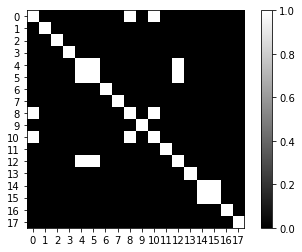

In [27]:
labels, ax = cgt.plot_similarity(above_cutoff=True)

since each row, column refers back to a node, we can add it to the graph!

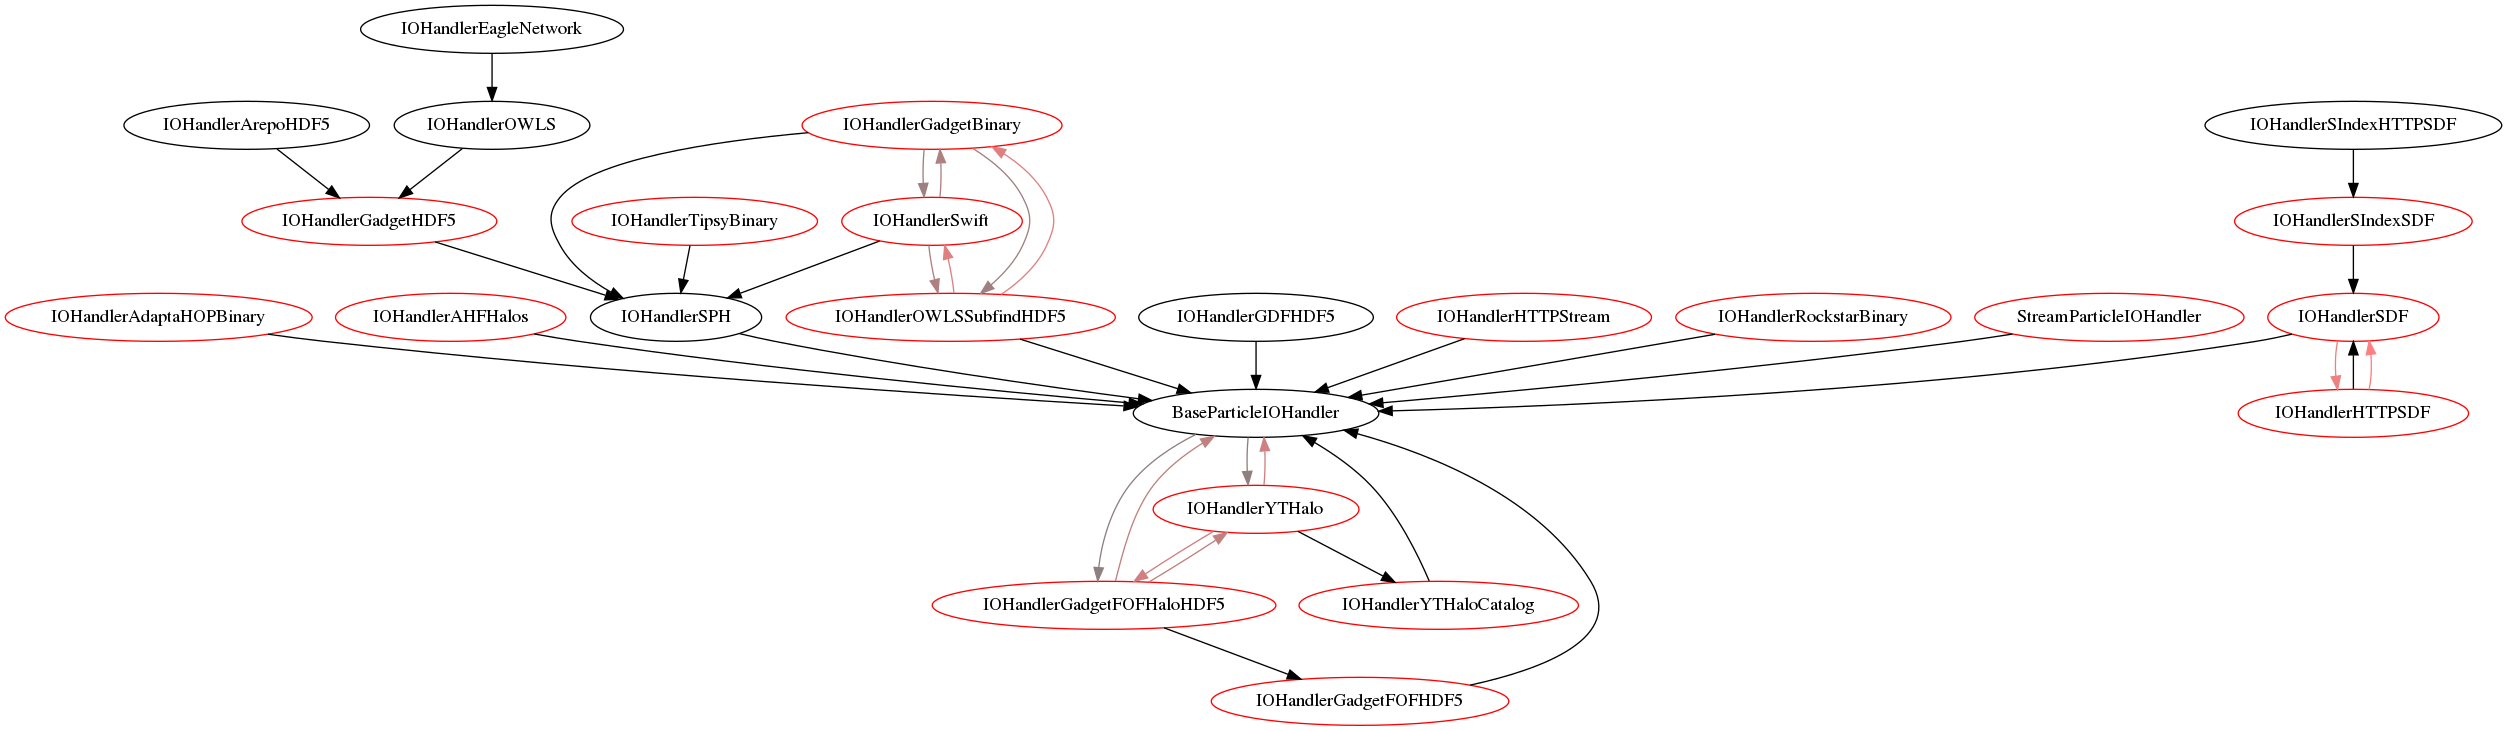

In [28]:
cgt.build_graph(include_similarity=True)
cgt.show_graph()

* black arrows: inheritance (same as before)
* red outlines: the selected function is overridden
* isolated red outline: did not find any other classes function source above cutoff
* colored arrows: point between classes containing function source above similarity cutoff. The actual color isn't meaningful... yet?

Look at that gadget, Halo loop! and the Swift, OWLs, Gadaget Binary loop!

The simimilarity loops distinct from inheritance structure suggests there are simplifications to be made!

## 3. interactivity with pyvis!

It'd be nice to have the above plot be interactive... 

`pyvis` (https://pyvis.readthedocs.io/en/latest/) can render graphs interactively in a notebook (interfaces with `networkx`, https://networkx.org/).

Rebuild the graph with `networkx`, then wrap with `pyvis.network.Network(notebook=True, ...)`

In [29]:
import yt
from inheritance_explorer import ClassGraphTree
# base_class = yt.utilities.io_handler.BaseIOHandler
base_class = yt.utilities.io_handler.BaseParticleIOHandler
# fname = "_read_particle_selection"
fname = "_read_particle_coords"

cgt = ClassGraphTree(base_class, 
                     funcname=fname, 
                     similarity_cutoff=0.75)
graph = cgt.build_interactive_graph(width="1200px", 
                                    height="800px", 
                                    bgcolor='#222222', 
                                    font_color='white')
# graph.show_buttons(filter_=['physics'])
# graph.show_buttons(filter_=['edges'])
# graph.show_buttons(filter_=['nodes'])
graph.show('tmp.html')

* Gray edges: point from child to parent classes
* Blue-Purple nodes: this child over-rides the selected function
* blue edges: connect child classes that over-ride the selected function AND are greater than 75% similar
* isolated blue-purple nodes = over-rides that are below similarity cutoff (75%)

So now we can graphically pick out frontends with likely code duplication... would be nice to be able to view the source code interactively here. 

Separate-ish work from Matt on a source code explorer via ipywidgets:

In [30]:
import yt
import inspect
import ipywidgets
import traitlets

from IPython.display import Markdown, display
import textwrap
import collections

In [31]:
base_class = BaseParticleIOHandler

all_subclasses = []
def subclasses_assemble(parent):
    for child in parent.__subclasses__(): 
        all_subclasses.append(child)  # add the name        
        subclasses_assemble(child)  # continue downward... 
    
subclasses_assemble(base_class)

# sort classes alphabetically  
s_c_strings = [i.__name__ for i in all_subclasses]
sorted_subclsses = [x for _, x in sorted(zip(s_c_strings, all_subclasses))]
sorted_subclsses

class_dropdown = ipywidgets.Dropdown(options=[(_.__name__, _) for _ in sorted_subclsses])
func_dropdown = ipywidgets.Dropdown(options=[_ for _ in dir(base_class) if not _.startswith("__")])
defined_at = ipywidgets.HTML()
source = ipywidgets.Output(layout=ipywidgets.Layout(width="100%", height="40em"))


def update_class(event):
    current_func = func_dropdown.value
    func_dropdown.options = [_ for _ in dir(class_dropdown.value) if not _.startswith("__")]
    if current_func in func_dropdown.options:
        func_dropdown.value = current_func

update_class(None)
class_dropdown.observe(update_class, ["value"])
    
def update_source(event):
    cls = class_dropdown.value
    f = getattr(cls, func_dropdown.value)
    
    source.clear_output()
    if not isinstance(f, collections.abc.Callable): return
    defined_at.value = f"<tt>{inspect.getsourcefile(f)}:{inspect.getsourcelines(f)[1]}</tt>"
    with source:
        display(
            Markdown(
                data="```python\n"
                + textwrap.dedent(inspect.getsource(f))
                + "\n```"
            )
        )

func_dropdown.observe(update_source, ["value"])
class_dropdown.observe(update_class, ["value"])
update_source(None)
display(ipywidgets.VBox([class_dropdown, func_dropdown, defined_at, source]))

# checkout out _read_particle_coords, Swift vs Gadget vs OWLSSubfind (uses Gadget)

would **love** to be able to multi-select nodes interactively and  display source code... might need a more customizable node editor? pyvis only has non-interactive hover labels, specific actions when clicking a node.

### other improvements?

* **the graph**: color nodes or arrow by similarity value using a colormap
* **code similarity**: other methods or packages to look at? pylint or similar seem more concerned with cross-file comparisons...
* **other interactive options?** more complex hover info: click a node, get a panel (like in the node editors?) for viewing source
* any other parts of yt (or other packages) that might be interesting to map out? 


## other examples

In [32]:
import yt
from inheritance_explorer import ClassGraphTree

base_class = yt.data_objects.static_output.Dataset
fname = "_parse_parameter_file"

cgt = ClassGraphTree(base_class, funcname=fname) # traces an inheritance tree
graph = cgt.build_interactive_graph(width="1200px", 
                                    height="800px", 
                                    bgcolor='#222222', 
                                    font_color='white') # constructs a pyvis interactive graph
graph.show('_tmp.html')  # a pyvis interactive graph

In [33]:
base_class = yt.fields.field_info_container.FieldInfoContainer
fname = "setup_particle_fields"

cgt = ClassGraphTree(base_class, funcname=fname) # traces an inheritance tree
graph = cgt.build_interactive_graph(width="1200px", 
                                    height="800px", 
                                    bgcolor='#222222', 
                                    font_color='white') # constructs a pyvis interactive graph
graph.show('__tmp.html')  # a pyvis interactive graph

In [34]:
base_class = yt.fields.field_info_container.FieldInfoContainer
fname = "setup_fluid_fields"

cgt = ClassGraphTree(base_class, 
                     funcname=fname, 
                     similarity_cutoff=0.9) # traces an inheritance tree
graph = cgt.build_interactive_graph(width="1200px", 
                                    height="800px", 
                                    bgcolor='#222222', 
                                    font_color='white') # constructs a pyvis interactive graph
graph.show('___tmp.html')  # a pyvis interactive graph

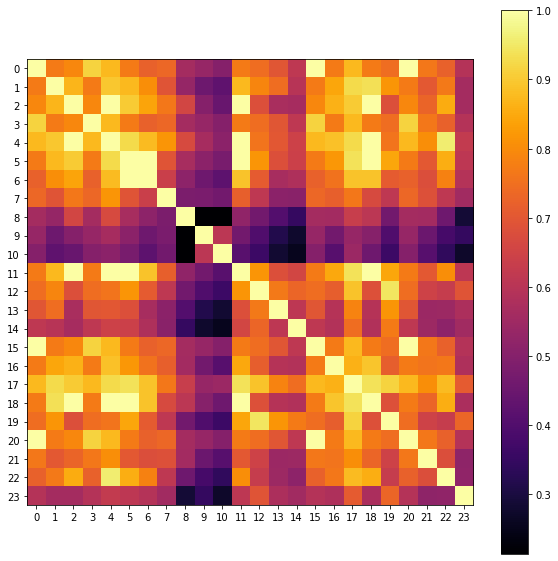

In [35]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
labels, ax = cgt.plot_similarity(ax=ax, cmap="inferno")

but some of these are only similar because `FieldInfoContainer` is a true abstract base class... and so some of these child classes are over-riding with just 

```python 
def setup_fluid_fields(self):
    pass
```

So as to not error on instantation... would be nice to control for that in the similarity calculation... 
    

also, what's up with that one inheritance sequence on the owls path (11 -> 15 -> 16)